In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!echo "deb https://integrativemodeling.org/latest/download $(lsb_release -cs)/" > /etc/apt/sources.list.d/salilab.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 22A3BF2B
!apt update
!apt install imp
import sys
sys.path.append('/usr/lib/python3.6/dist-packages')

Executing: /tmp/apt-key-gpghome.zSexxsX1n2/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 22A3BF2B
gpg: key EE70051722A3BF2B: public key "Ben Webb <ben@salilab.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 htt

In [6]:
import os
import pickle

import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

import sys
import IMP
import IMP.atom
import IMP.algebra
import IMP.rmf
import IMP.core
import RMF
import IMP.container
import IMP.display
import IMP.npctransport
import numpy as np
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm


import IMP.atom
import IMP.algebra
import IMP.rmf
import IMP.core
import RMF
import IMP.container
import IMP.display
import IMP.npctransport

In [7]:


k_out_list = np.logspace(-3, -0.5, 15, base=10)
radius_list = np.logspace(2, 3, 8, base=10)


###################### biological stuff ######################

N_A = 6.022E23
L_PER_A3 = 1E-27

def get_sphere_vol(R):
      return 4/3 * np.pi * (R ** 3)

def get_concentration_M(n_chains, R):
      return (n_chains / get_sphere_vol(R)) / N_A / L_PER_A3

###################### pickling it up ######################

def generate_file_ending(k_out, sphere_radius):
    """
    generate file ending per given k or sphere
    """
    kout = f'{k_out:.3f}'
    spr_rad = f'{sphere_radius:.3f}'

    current_string = "kout_" + kout + "_" + "spr_rad_" + spr_rad
    return current_string


def load_pickles_to_arrays(k_out, sphere_radius):
    """
    method to load pickles to arrays
    """
    cwd = "/content/drive/MyDrive/Run4"
    current = generate_file_ending(k_out, sphere_radius)
    with open(cwd + '/T_ns_' + current + ".pkl", 'rb') as f:
        T_ns = pickle.load(f)
    with open(cwd + '/Energy_' + current + ".pkl", 'rb') as f:
        E = pickle.load(f)
    with open(cwd + '/Distance-e-to-e_' + current + ".pkl", 'rb') as f:
        D = pickle.load(f)
    with open(cwd + '/chain_on_iterations_' + current + ".pkl", 'rb') as f:
        chains_on_iterations = pickle.load(f)
        #chains_on_iterations = back_to_XYZs(chains_on_iterations)
    return T_ns, chains_on_iterations

def load_big_matrix(k_out, sphere_radius):
    cwd = "/content/drive/MyDrive/Run4"
    current = generate_file_ending(k_out, sphere_radius)
    with open(cwd + '/chain_on_iterations_' + current + ".pkl", 'rb') as f:
        chains_on_iterations = pickle.load(f)
    return chains_on_iterations

def load_T_ns(k_out, sphere_radius):
    cwd = "/content/drive/MyDrive/Run4"
    current = generate_file_ending(k_out, sphere_radius)
    with open(cwd + '/T_ns_' + current + ".pkl", 'rb') as f:
        T_ns = pickle.load(f)
    return T_ns

  

def back_to_XYZs(chains_on_iterations):
    """
    method to turn beads into XYZs again
    """
    n_chains_on_iterations = []
    for current_iteration_chains in chains_on_iterations:
        # for each iteratio
        n_chains_on_iters = []
        for chain in current_iteration_chains:
            # we go through each chain
            n_chain = []
            for bead in chain:
                # and turn each bead into a Vector
                n_chain.append(IMP.algebra.Vector3D(bead))
            # so we add the new chain of beads into the current iteration
            # chains
            n_chains_on_iters.append(n_chain)
        # and all of the chains of current iter we add to array of iterations
        n_chains_on_iterations.append(n_chains_on_iters)
    return n_chains_on_iterations


def var_array_generator(array):
    """
    generate variance over given array
    """
    vars = []
    for cen in array:
        iteration_var = np.var(np.array(cen))
        vars.append(iteration_var)

    vars = np.array(vars)
    return vars


###################### helpers ######################

def calculate_center_of_mass(chainVecs: IMP.algebra.Vector3Ds):
    """
    calculate center of mass of current chain position
    """
    return IMP.algebra.get_centroid(chainVecs)


###################### plot generators ######################

def generate_heatmap(data, labels_dict, file_title, plot_title):
    """
    method to generate heatmap with name file title of the given data
    """
  

    fig = plt.figure()
    
    ax = sn.heatmap(data,
                    linewidths=0.3, 
                    xticklabels=np.array(["%.6f" % get_concentration_M(2, r) for r in radius_list]))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    figure = ax.get_figure()

    if labels_dict:
        ax.set_xlabel(labels_dict["x"])
        ax.set_ylabel(labels_dict["y"])
    if plot_title:
        ax.set_title(plot_title)

    figure.savefig(file_title)


def generate_history_plot(data, labels_dict, file_title, plot_title):
    """
    method to get history plot out of given data
    """
    fig = plt.figure()
    ax = sns.histplot(data)

    if labels_dict:
        ax.set_xlabel(labels_dict["x"])
    if plot_title:
        ax.set_title(plot_title)

    plt.show()
    # plt.savefig(file_title)


def generate_2D_scatter_plot(x, y, labels_dict, file_title, plot_title):
    """
    method to generate 2D scatter plot
    """
    fig = plt.figure()
    plt.scatter(x, y)

    if labels_dict:
        plt.xlabel(labels_dict["x"])
        plt.ylabel(labels_dict["y"])
    if plot_title:
        plt.title(plot_title)

    plt.savefig(file_title)


def generate_3D_scatter_plot(x, y, z, labels_dict, file_title, plot_title):
    """
    method to generate 3D scatter plot
    """
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(x, y, z,
               marker=".")

    if labels_dict:
        ax.set_xlabel(labels_dict["x"])
        ax.set_ylabel(labels_dict["y"])
        ax.set_zlabel(labels_dict["z"])
    if plot_title:
        ax.set_title(plot_title)

    plt.savefig(file_title)


def generate_2D_N_plots(x, y, labels_dict, file_title, plot_title, no_start):
    """
    generate 2d plot with several plots on it
    """

    fig = plt.figure()

    for sub_y in y:
        sub_y = sub_y[no_start]
        plt.plot(x, sub_y)

    if labels_dict:
        plt.xlabel(labels_dict["x"])
        plt.ylabel(labels_dict["y"])
    if plot_title:
        plt.title(plot_title)

    plt.savefig(file_title)


def generate_2D_plot(x, y, labels_dict, file_title, plot_title):
    """
    generate simple 2d plot
    """
    fig = plt.figure()
    plt.plot(x, y)

    if labels_dict:
        plt.xlabel(labels_dict["x"])
        plt.ylabel(labels_dict["y"])
    if plot_title:
        plt.title(plot_title)

    plt.savefig(file_title)


###################### wanted plots ######################

def simulation_energy_over_time(E, T_ns, T_ns_threshold):
    """
    method to create function of energy as a function of time
    """
    no_start = (T_ns > T_ns_threshold)
    # (x, y, labels_dict, file_title, plot_title)
    generate_2D_plot(T_ns[no_start], E[no_start],
                     {'x': r'time [$ns$]',
                      'y': r'E [$kcal/mol/A^2$]'},
                     "energy_graph",
                     "Energy(time) graph")


def end_to_end_distances_over_time(D, T_ns, T_ns_threshold):
    """
    method to create plot of distances of end to end as
    a function of time
    """
    no_start = (T_ns > T_ns_threshold)
    # (x, y, labels_dict, file_title, plot_title)
    generate_2D_N_plots(T_ns[no_start], D,
                        {'x': r'time [$ns$]',
                         'y': r'end-to-end distance [$A$]'},
                        "distances_graph",
                        "end to end Distances(time) graph",
                        no_start)


def distribution_of_energy_over_time(E, T_ns, T_ns_threshold):
    """
    method to create plot of distribution of energy over time
    """
    no_start = (T_ns > T_ns_threshold)
    generate_history_plot(E[no_start],
                          {"x": r'energy [$kcal^{-1}mol^{-1}A^2$]'},
                          "dist_of_E",
                          "distribution of Energy history plot")


def distribution_of_dist_over_time(D):
    """
    method to get distribution of distances over time
    """
    D_concat = np.concatenate(D[0:])
    generate_history_plot(D_concat,
                          {"x": r'N''-C'' distance [A]'},
                          "dist_of_D",
                          "distribution of Distances history plot")


def distribution_of_beads_locations(iter_chains, T_ns, T_ns_threshold):
    """
    get distribution of center masses of chains as a function of iterations
    """
    # each value inside centers is an array, for current iteration
    # each array contains all centers of frame, per the current iteration
    # centers = C[i][j] -> center of j'th chain in i'th iteration
    no_start = (T_ns > T_ns_threshold)

    iter_chains = back_to_XYZs(iter_chains)
    centers = [[calculate_center_of_mass(chain) for chain in
                chains_on_cur_iteration] for
               chains_on_cur_iteration in iter_chains]

    vars = var_array_generator(centers)
    # the plot itself
    generate_2D_plot(T_ns[no_start], vars[no_start],
                     {'x': r'time [$ns$]',
                      'y': r'variance of center of mass'},
                     "variance_of_centers",
                     "Var(time) graph")


def check_file_existing(k_out, sphere_radius,full_path):
    """
    check file existence is current folder
    """
    cwd = full_path
    file_names = ['/T_ns_', 
                  '/chain_on_iterations_']

    kout = f'{k_out:.3f}'
    spr_rad = f'{sphere_radius:.3f}'

    current = "kout_" + kout + "_" + "spr_rad_" + spr_rad
    for file_name in file_names:
        #print (cwd + file_name + current + ".pkl")
        if not os.path.exists(cwd + file_name + current + ".pkl"):
            return False
    return True


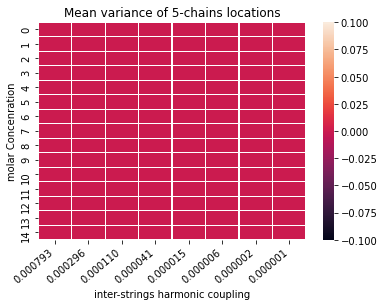

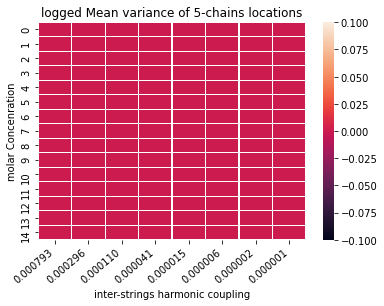

In [8]:

from tqdm import tqdm
import numpy as np

data_path = "/content/drive/MyDrive/Run4"  # TODO: change path if needed

T_thresh = 1
N_CHAINS = 5
kS = np.logspace(-3, -0.5, 15, base=10)
rads = np.logspace(2, 3, 8, base=10)

heatmap_data = np.zeros((len(kS), len(rads)))

n_chains = 5
full_path = "/content/drive/MyDrive/Run4"

# for k, k_out in enumerate(kS):
#     for rad, spr_rad in enumerate(rads):
#         if check_file_existing(k_out, spr_rad,full_path):
#             vars = []
#             T_ns, matrix = load_T_ns(k_out, spr_rad), load_big_matrix(k_out, spr_rad)
#             mat = back_to_XYZs(matrix)
#             for i,iter in enumerate(mat):
#                 for c,chain in enumerate(iter):
#                     matrix[i][c] = calculate_center_of_mass(
#                         chain)  # replacing all chain's bead with 1 center of mass
#                 vars.append(var_array_generator(matrix[i]) / n_chains)
#             heatmap_data[k, rad] = np.mean(vars)

plot_title = "Mean variance of 5-chains locations"
file_title = "variance"
labels_dict = {"y": "molar Concenration",
               "x": "inter-strings harmonic coupling"}
generate_heatmap(heatmap_data, labels_dict, file_title, plot_title)
logged = np.max(np.log1p(heatmap_data)) - np.log1p(heatmap_data)
generate_heatmap(logged, labels_dict, file_title, "logged " + plot_title)